In [1]:
!wget -N https://lcps.nu/wp-content/uploads/covid-19.csv

--2021-01-11 14:17:25--  https://lcps.nu/wp-content/uploads/covid-19.csv
Resolving lcps.nu (lcps.nu)... 62.221.199.13, 2001:1460:3:0:1c00:d3ff:fe00:cb9
Connecting to lcps.nu (lcps.nu)|62.221.199.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6105 (6.0K) [text/csv]
Saving to: ‘covid-19.csv’

covid-19.csv        100%[===================>]   5.96K  --.-KB/s    in 0s      

2021-01-11 14:17:25 (211 MB/s) - ‘covid-19.csv’ saved [6105/6105]



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [2]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [3]:
df = pd.read_csv(
    'covid-19.csv',
    keep_default_na=False,
    na_values='',
    parse_dates=[0],
    dayfirst=True)
df.head(10)

Datum  IC_Bedden_COVID  IC_Bedden_Non_COVID  Kliniek_Bedden  \
0 2021-01-11              702                  383            1926   
1 2021-01-10              711                  379            1850   
2 2021-01-09              700                  420            1874   
3 2021-01-08              708                  426            1936   
4 2021-01-07              712                  420            2052   
5 2021-01-06              704                  435            2131   
6 2021-01-05              731                  396            2159   
7 2021-01-04              715                  377            2130   
8 2021-01-03              704                  360            2006   
9 2021-01-02              698                  379            2005   

   IC_Nieuwe_Opnames_COVID  Kliniek_Nieuwe_Opnames_COVID  
0                     24.0                         173.0  
1                     25.0                         187.0  
2                     44.0                         241.0  
3                     37.0                         249.0  
4                     29.0                         231.0  
5                     39.0                         262.0  
6                     46.0                         320.0  
7                     41.0                         226.0  
8                     29.0                         241.0  
9                     37.0                         248.0

Adding structure and dummy variables, last check of our source dataframe.

In [4]:
df['Source']    = 'LCPS'
df['Capacity']  = 1
df['IC_totaal'] = df['IC_Bedden_COVID'] + df['IC_Bedden_Non_COVID']

df.describe().transpose()

count        mean         std    min    25%  \
IC_Bedden_COVID               225.0  259.844444  252.451565   14.0   34.0   
IC_Bedden_Non_COVID           225.0  528.315556   65.350039  360.0  480.0   
Kliniek_Bedden                225.0  778.893333  707.332948   63.0  120.0   
IC_Nieuwe_Opnames_COVID        87.0   37.758621   12.040596   18.0   29.0   
Kliniek_Nieuwe_Opnames_COVID   87.0  225.666667   58.142301  112.0  184.5   
Capacity                      225.0    1.000000    0.000000    1.0    1.0   
IC_totaal                     225.0  788.160000  199.333132  537.0  612.0   

                                50%     75%     max  
IC_Bedden_COVID               113.0   526.0   731.0  
IC_Bedden_Non_COVID           543.0   578.0   646.0  
Kliniek_Bedden                456.0  1440.0  2159.0  
IC_Nieuwe_Opnames_COVID        37.0    44.5    76.0  
Kliniek_Nieuwe_Opnames_COVID  223.0   257.0   430.0  
Capacity                        1.0     1.0     1.0  
IC_totaal                     685.0  1015.0  1139.0

We pivot to a source by column format.

In [5]:
# File parameters prefixed pf_

pf_datcol = 'Datum'                       # date column
pf_dimcol = 'Source'                      # dimension column (location or otherwise)
pf_cascol = ['IC_Nieuwe_Opnames_COVID', 'Kliniek_Nieuwe_Opnames_COVID']
pf_namcol = 'Source'                      # full dim name
pf_popcol = 'Capacity'                    # population column

pf_futext = '365 days'                    # future extension of dataframe

In [6]:
df_dim = df.pivot_table(
    index=pf_datcol,
    columns=pf_dimcol,
    values=pf_cascol,
    aggfunc='sum').fillna(0)
df_dim

IC_Nieuwe_Opnames_COVID Kliniek_Nieuwe_Opnames_COVID
Source                        LCPS                         LCPS
Datum                                                          
2020-06-01                     0.0                          0.0
2020-06-02                     0.0                          0.0
2020-06-03                     0.0                          0.0
2020-06-04                     0.0                          0.0
2020-06-05                     0.0                          0.0
...                            ...                          ...
2021-01-07                    29.0                        231.0
2021-01-08                    37.0                        249.0
2021-01-09                    44.0                        241.0
2021-01-10                    25.0                        187.0
2021-01-11                    24.0                        173.0

[225 rows x 2 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [7]:
new_index = pd.date_range(
    df_dim.index.min(),
    df_dim.index.max() + pd.Timedelta(pf_futext))
df_dim = df_dim.reindex(new_index)
df_dim

IC_Nieuwe_Opnames_COVID Kliniek_Nieuwe_Opnames_COVID
Source                        LCPS                         LCPS
2020-06-01                     0.0                          0.0
2020-06-02                     0.0                          0.0
2020-06-03                     0.0                          0.0
2020-06-04                     0.0                          0.0
2020-06-05                     0.0                          0.0
...                            ...                          ...
2022-01-07                     NaN                          NaN
2022-01-08                     NaN                          NaN
2022-01-09                     NaN                          NaN
2022-01-10                     NaN                          NaN
2022-01-11                     NaN                          NaN

[590 rows x 2 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [8]:
df_dim['daynum'] = (df_dim.index - df_dim.index.min()).days
df_dim['daynum'].describe()

count    590.000000
mean     294.500000
std      170.462606
min        0.000000
25%      147.250000
50%      294.500000
75%      441.750000
max      589.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`.

In [9]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

In [10]:
# Run parameters prefixed pr_

pr_dim      = 'LCPS'                         # dimension indicator (geo or otherwise)

pr_measure  = 'Kliniek_Nieuwe_Opnames_COVID' # file column to use as measure
pr_smeasure = 'Week window'                  # smoothed measures
pr_rmeasure = 'rcases'                       # remaining measures after iteration
pr_pmeasure = 'Model'                        # projected measures summed
pr_wmeasure = 'Wave '                        # wave name prefix, zero-leading number is added
pr_wavenum  = 2                              # wave numbering width

pr_sdays    = 7                              # number of days for smoothing window
pr_firstwav = 1                              # initial wave number
pr_popcases = 1e6                            # relative minimum from population size (one in n cases)
pr_mincases = 2                              # absolute minimum number of cases to consider

pr_linmax   = -0.5                           # upper bound of linear derivation
pr_linmin   = -5.0                           # lower bound of linear derivation
pr_betamax  = 55                             # maximum accepted beta estimate
pr_datamin  = 3                              # minimum number of data points in spline
pr_projmin  = 1                              # minimum cases for projected start and floor
pr_gradmin  = 1e-6                           # minimum gradient difference for knot

pr_plotmin  = '20201001'                     # start date of output plots
pr_plotmax  = '20210301'                     # final date of output plots

pr_earth = {'minspan'     : 1,
            'penalty'     : 0,
            'endspan'     : 0,
            'thresh'      : 1e-9,
            'check_every' : 1} 

In [11]:
wave = pr_firstwav

# Initialize predicted measure, create smoothed measure and remaining cases
df_dim[(pr_pmeasure, pr_dim)] = 0
df_dim[(pr_smeasure, pr_dim)] = df_dim[pr_measure][pr_dim].loc[:].rolling(pr_sdays).mean()
df_dim[(pr_rmeasure, pr_dim)] = df_dim[pr_smeasure][pr_dim]

# Always plot smoothed and predicted measures, adding waves when found
plotlist = [(pr_smeasure, pr_dim), (pr_pmeasure, pr_dim)]

In [12]:
# Get full name and population from the original dataset
dimnam = df[df[pf_dimcol] == pr_dim][pf_namcol].iloc[0]
dimpop = df[df[pf_dimcol] == pr_dim][pf_popcol].iloc[0]

# We use relative minimum cases, but at least an absolute minimum
mincases = max(dimpop / pr_popcases, pr_mincases)

In [13]:
print('Running multiple wave analysis for {} with population {:1.0f}'.format(dimnam, dimpop))
print('Minimum number of cases is {:1.0f}'.format(mincases))

while True:
    # Create potential wave
    curwave = pr_wmeasure + str((wave) + (10 ** pr_wavenum))[-pr_wavenum:]
    df_dim[(curwave, pr_dim)] = 0

    # Create a dataframe for projections
    df_proj = pd.DataFrame({'daynum':df_dim['daynum'],
                            'measure':df_dim[pr_rmeasure][pr_dim]})

    # Create the Gumbel division and select suitable measures
    df_proj['gumdiv'] = df_proj['measure'] / df_proj['measure'].cumsum()
    df_proj = df_proj[(df_proj['gumdiv'] > 0) & (df_proj['measure'] > mincases)]

    # Reduce to log scale and select relevant measures
    df_proj['linear'] = np.log(df_proj['gumdiv'])
    df_proj = df_proj[(df_proj['linear'] < pr_linmax) &
                      (df_proj['linear'] > pr_linmin)]

    # Do we still have data left?
    if len(df_proj) <= 1:
        print('--- no data left')
        break
    
    # Create input vectors for regression splines and build a model
    eax = df_proj['daynum'].values.reshape(-1, 1)
    eay = df_proj['linear'].values.reshape(-1, 1)
    #eamodel = Earth()
    #eamodel = Earth(minspan=0)
    #eamodel = Earth(minspan=1, penalty=0, endspan=0, thresh=1e-9, check_every=1)
    eamodel = Earth(**pr_earth)
    eamodel.fit(eax, eay)

    # Store the results
    df_proj['earth'] = eamodel.predict(eax)

    # Find the day range
    daymin = df_proj['daynum'].min()
    daymax = df_proj['daynum'].max()

    # Find the gradient of generated regression splines
    df_proj['eagrad'] = df_proj['earth'] - df_proj['earth'].shift(1)
    
    # Knots are found when the gradient changes, including start and end
    df_proj['knot'] = ((abs(df_proj['eagrad'] - df_proj['eagrad'].shift(1)) > pr_gradmin) |
                       (df_proj['daynum'] == (daymin + 1)) |
                       (df_proj['daynum'] == daymax))

    # Starting day of each spline
    df_proj['daycount'] = df_proj.reset_index().index

    # Select the knots and find the actual number of days for each spline
    df_knot = df_proj[df_proj['knot']][['daynum', 'daycount', 'eagrad']]
    df_knot['daysdata'] = df_knot['daycount'].shift(-1) - df_knot['daycount']
    
    # Candidate knots have a negative gradient and a minimum number of days
    df_knot['cand'] = ((df_knot['eagrad'] < -(1 / pr_betamax)) &
                       (df_knot['daysdata'] >= pr_datamin))

    # We want early knots with a low gradient and many days
    df_knot['since'] = df_knot['daynum'] - daymin
    df_knot['score'] = (df_knot['eagrad'] ** 2) * np.sqrt(df_knot['daysdata'] / np.sqrt(df_knot['since']))
    df_knot['choice'] = df_knot['score'] == df_knot[df_knot['cand']]['score'].max()

    # Did we find another wave?
    choice = df_knot[df_knot['choice']]
    if len(choice) == 0:
        print('--- no data for wave')
        break
    
    # Find the interval of the selected spline
    lower = choice['daynum'].values[0]
    upper = choice['daysdata'].values[0] + lower
    df_proj = df_proj[(df_proj['daynum'] >= lower) &
                      (df_proj['daynum'] <= upper)].copy()

    # Calculate slope and intercept as basis for beta and mu
    fitmod = export.export_python_function(eamodel)
    slope = (fitmod([[upper]])[0] - fitmod([[lower]])[0]) / (upper - lower)
    intercept = fitmod([[lower]])[0] - (lower * slope)
    beta = - 1 / slope
    mu = beta * (intercept + np.log(beta))

    # Apply the Gumbel PDF according to beta and mu to find the scale and fit
    df_proj['pgumb'] = gumpdf(df_proj['daynum'], beta, mu)
    df_proj['scale'] = df_proj['measure'] / df_proj['pgumb']
    final = df_proj['scale'].mean()
    fincv = df_proj['scale'].std() / final

    # Calculate the current wave and its parameters
    df_dim[(curwave, pr_dim)] = final * gumpdf(df_dim['daynum'], beta, mu)
    peak = df_dim[df_dim[(curwave, pr_dim)] == df_dim[(curwave, pr_dim)].max()].index.min()
    start = df_dim[(df_dim[(curwave, pr_dim)] >= pr_projmin) &
                   (df_dim[(curwave, pr_dim)].index < peak)].index.min()
    floor = df_dim[(df_dim[(curwave, pr_dim)] < pr_projmin) &
                   (df_dim[(curwave, pr_dim)].index > peak)].index.min()
    print('{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'.format(
        curwave, beta, mu, (1 - fincv) ** 2, peak.date(), start.date(), floor.date(), final))

    # Move the associated measures from remainder to prediction
    df_dim[(pr_pmeasure, pr_dim)] += df_dim[(curwave, pr_dim)]
    df_dim[(pr_rmeasure, pr_dim)] -= df_dim[(curwave, pr_dim)]
    plotlist += [(curwave, pr_dim)]
    wave += 1

Running multiple wave analysis for LCPS with population 1
Minimum number of cases is 2
Wave 01 beta  6.549 mu 147 fit 0.916 peak 2020-10-26 from 2020-10-13 to 2020-12-09 size 4527
Wave 02 beta  5.283 mu 158 fit 0.921 peak 2020-11-06 from 2020-10-26 to 2020-12-08 size 2104
Wave 03 beta  4.582 mu 167 fit 0.893 peak 2020-11-15 from 2020-11-06 to 2020-12-11 size 1197
Wave 04 beta  5.763 mu 177 fit 0.980 peak 2020-11-25 from 2020-11-13 to 2020-12-29 size 2209
Wave 05 beta 10.008 mu 195 fit 0.936 peak 2020-12-13 from 2020-11-22 to 2021-02-11 size 4056
Wave 06 beta  5.032 mu 200 fit 0.863 peak 2020-12-18 from 2020-12-09 to 2021-01-13 size 776
Wave 07 beta  7.084 mu 211 fit 0.886 peak 2020-12-29 from 2020-12-15 to 2021-02-12 size 3861
Wave 08 beta  4.354 mu 219 fit 0.895 peak 2021-01-06 from 2020-12-29 to 2021-01-30 size 1066
--- no data for wave


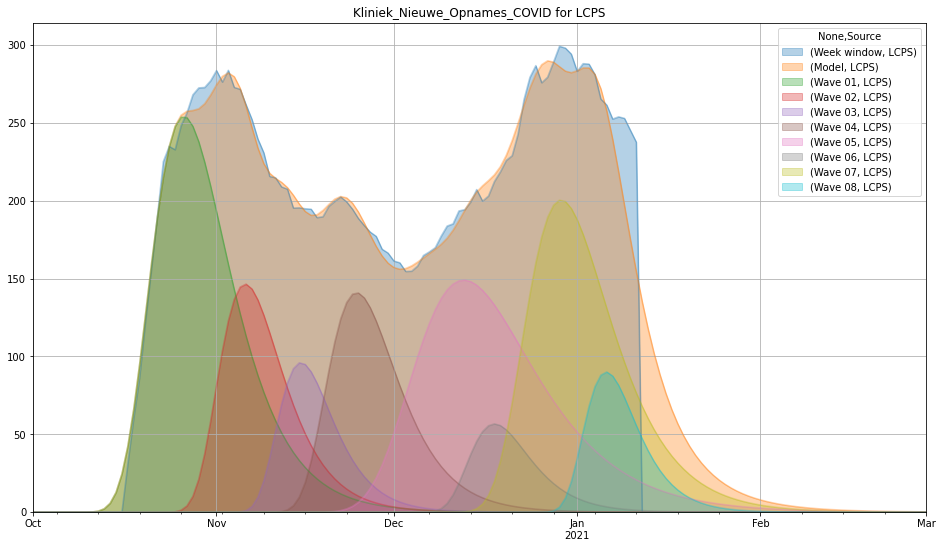

In [14]:
df_dim[plotlist].loc[pr_plotmin:pr_plotmax].plot(
    figsize=(16, 9),
    grid=True,
    kind='area',
    stacked=False,
    alpha=1/3,
    title=pr_measure+' for '+dimnam)

Residuals from fit are the cases left.

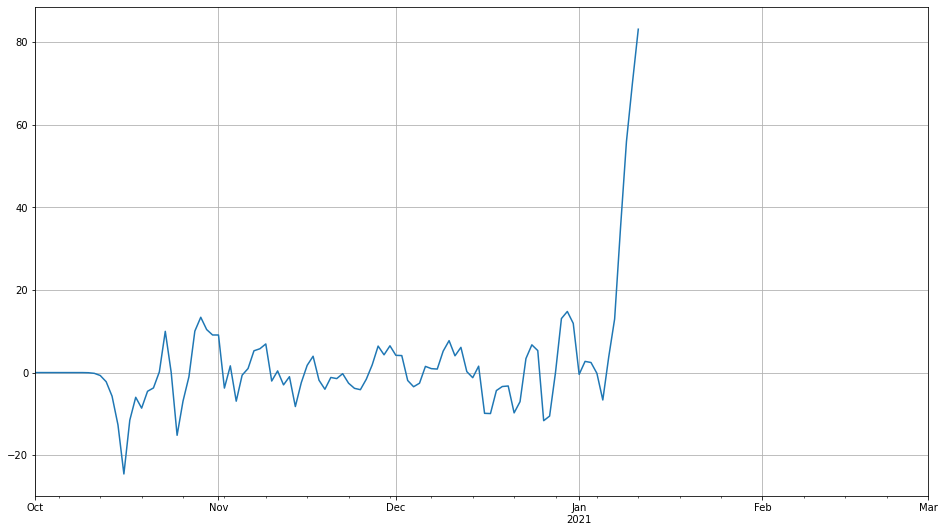

In [15]:
(df_dim[(pr_smeasure, pr_dim)] - df_dim[(pr_pmeasure, pr_dim)]).loc[pr_plotmin:pr_plotmax].plot(
    figsize=(16, 9),
    grid=True)

Keep exploring! Stay home, wash your hands, keep your distance.